# Exercise sheet 12 -  Astronomical Data Analysis

### Question 1

Smooth the image `MACSJ0416_HAWKI.fits` from the previous exercise with ``scipy.ndimage.gaussian_filter``
   using a kernel size of your preference (please explore!). Subtract the smoothed image from the original one.  Save the smoothed _and_ subtracted images in ``fits`` format (using `astropy`) and display them with with e.g. ``ginga``
  (or ``ds9``).

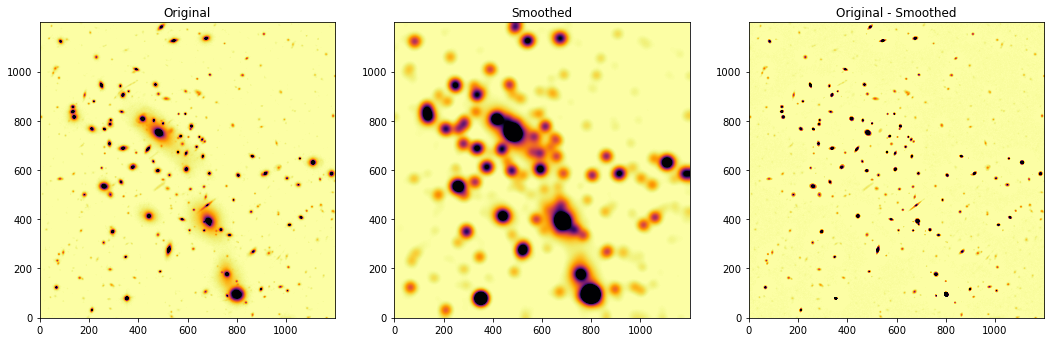

In [6]:
from astropy.io import fits
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm 
import numpy as np

filename = "../../Exercise_11/MACSJ0416_HAWKI.fits"

data = fits.getdata(filename)
header = fits.getheader(filename)

smoothed = gaussian_filter(data, sigma=15)

residual = data - smoothed

smoothed_hdu = fits.PrimaryHDU(data=smoothed, header=header)
residual_hdu = fits.PrimaryHDU(data=residual, header=header)

smoothed_hdu.writeto("MACSJ0416_HAWKI.smt.fits", overwrite=True)
residual_hdu.writeto("MACSJ0416_HAWKI.rsd.fits", overwrite=True)

#ploting here too

fig = plt.figure(figsize=(18,6))

plt.subplot(131)
vmin = np.median(data)
vmax = vmin + 3*np.std(data)
plt.imshow(data, origin="lower", vmin=vmin, vmax=vmax, cmap="inferno_r")
plt.title("Original")

plt.subplot(132)
vmin = np.median(smoothed)
vmax = vmin + 3*np.std(smoothed)
plt.imshow(smoothed, origin="lower", vmin=vmin, vmax=vmax, cmap="inferno_r")
plt.title("Smoothed")

plt.subplot(133)
vmin = np.median(residual)
vmax = vmin + 3*np.std(residual)
plt.imshow(residual, origin="lower", vmin=vmin, vmax=vmax, cmap="inferno_r")
plt.title("Original - Smoothed")

plt.savefig("Figures_Exercise1.pdf")


### Question 2

In Exercise 9, question 5 you were asked to go to the SDSS SkyServer at
   [http://skyserver.sdss.org/dr15/en/tools/search/radial.aspx](http://skyserver.sdss.org/dr15/en/tools/search/radial.aspx)
   and search for objects around a position on the sky, setting the search radius to 30 arcmin. Download the data, setting the number to output rows to "max" (=0) so all objects are returned.

   Load the data with ``astropy.table.Table`` (`XML`, `CSV`, `VOTable` and `FITS` formats should be
   supported) and create the following plots.

   - an histogram of the object magnitudes (in 0.5 mag bins). Try setting the y-axis to linear and then switch to logarithmic.

   - a plot of the magnitude (any of them) vs their errors.

   What can we say about the survey characteristics from these plots?

['objid', 'run', 'rerun', 'camcol', 'field', 'obj', 'type', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'Err_u', 'Err_g', 'Err_r', 'Err_i', 'Err_z']


(0.0, 1.5)

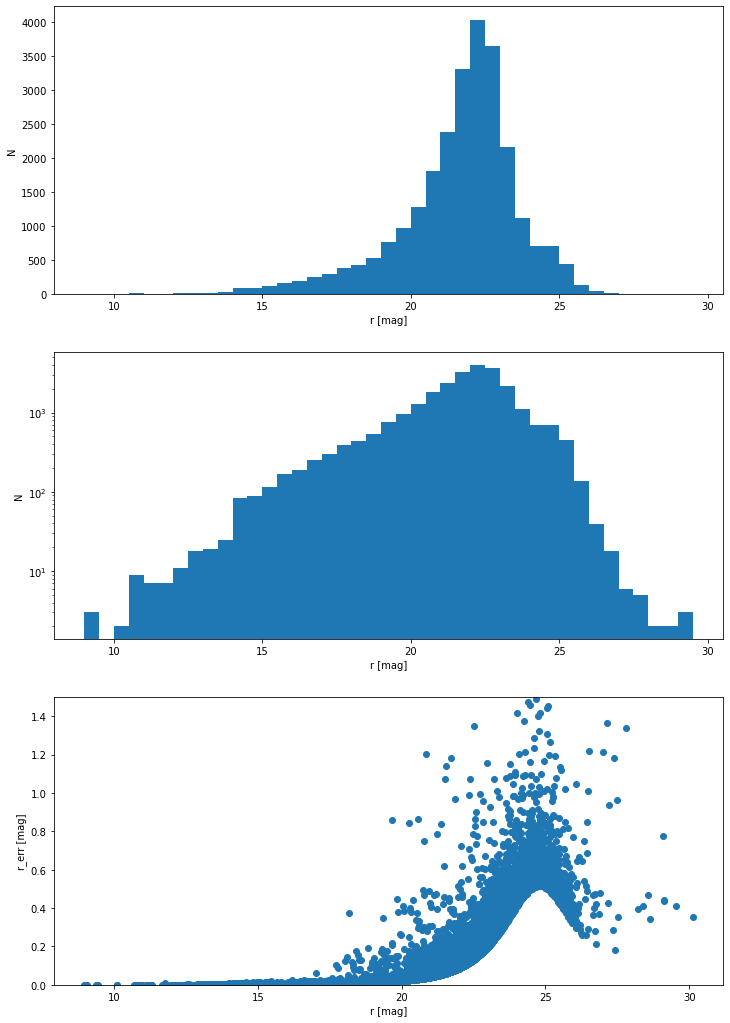

In [7]:
from astropy.table import Table

tbl = Table.read("Skyserver_Radial1.fits")
print(tbl.colnames)

mag = tbl["r"]
err = tbl["Err_r"]

fig = plt.figure(figsize=(12, 18))

plt.subplot(311)

bins = np.arange(9, 30, 0.5)
hist = plt.hist(mag, bins=bins)
plt.xlabel("r [mag]")
plt.ylabel("N")

plt.subplot(312)
bins = np.arange(9, 30, 0.5)
hist = plt.hist(mag, bins=bins)
plt.xlabel("r [mag]")
plt.ylabel("N")
plt.semilogy()

plt.subplot(313)
plt.plot(mag, err, "o" )
plt.xlabel("r [mag]")
plt.ylabel("r_err [mag]")
plt.ylim(0, 1.5)



### Question 3

Fit Gaussians profiles to the H$\alpha$ ($\lambda$=`6562.8 A`) and to the
   ``[OIII]`` ($\lambda$=`5007 A`) lines in the spectrum `SDSS_spec_galaxy.csv` and overplot the fits.
   You might need to subtract the spectral continuum to make the fitting to work.

  - What is the flux of these lines?

  - What is the `sigma` in `Angstrom` of these lines?

  - Transform these `sigma` to the velocity dispersion in `km/s`.

[OIII] center    5006.97, sigma      2.260, flux      233.1
Halpha center    6562.49, sigma      3.051, flux     3796.7

sigma [OIII] in km/s  135.33315364084706 km / s
sigma Halpha in km/s  139.38594118662505 km / s


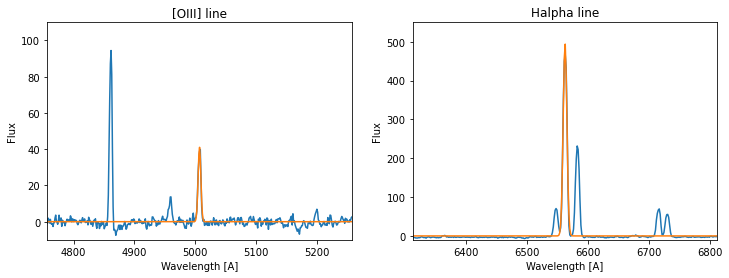

In [8]:
from scipy.optimize import curve_fit
import astropy.constants as const
import astropy.units as u

def gaussian(x, mean, sigma, amplitude):
    return amplitude * np.exp(-(x - mean)**2 / (2 * sigma**2.))

filename = "../../Exercise_11/SDSS_spec_galaxy.csv"

tbl = Table.read(filename)
wave = tbl["Wavelength"]
flux = tbl["Flux"]

z = wave[flux == flux.max()] / 6562.8  - 1

wave = wave / (1 + z)

plt.figure(figsize=(12, 4))

####### [OIII]  ##########

plt.subplot(121)

wave_cut = wave[(wave>5007 - 50) & (wave<5007 + 50)]
flux_cut = flux[(wave>5007 - 50) & (wave<5007 + 50)]

plt.plot(wave, flux - np.median(flux_cut))
plt.xlim(5007-250, 5007+250)
plt.ylim(-10, 110)
plt.title("[OIII] line")
plt.xlabel("Wavelength [A]")
plt.ylabel("Flux")

results, cov_matrix = curve_fit(gaussian, wave_cut, flux_cut - np.median(flux_cut), 
                                p0=[5007, 5, 100])
mean_o3 = results[0]
sigma_o3 = results[1]
amplitude_o3 = results[2]

plt.plot(wave, gaussian(wave, mean_o3, sigma_o3, amplitude_o3 ))

flux_o3 = np.trapz( gaussian(wave, mean_o3, sigma_o3, amplitude_o3 ), wave)


####### Halpha  ##########

plt.subplot(122)


wave_cut = wave[(wave>6562 - 50) & (wave<6562 + 50)]
flux_cut = flux[(wave>6562 - 50) & (wave<6562 + 50)]


plt.plot(wave, flux - np.median(flux_cut) )
plt.xlim(6562-250, 6562+250)
plt.ylim(-10, 550)
plt.title("Halpha line")
plt.xlabel("Wavelength [A]")
plt.ylabel("Flux")

results, cov_matrix = curve_fit(gaussian, wave_cut, flux_cut - np.median(flux_cut), 
                                p0=[6562, 1, 100], sigma=np.sqrt(wave_cut))
mean_ha = results[0]
sigma_ha = results[1]
amplitude_ha = results[2]

plt.plot(wave, gaussian(wave, mean_ha, sigma_ha, amplitude_ha))

flux_ha = np.trapz( gaussian(wave, mean_ha, sigma_ha, amplitude_ha ), wave)

print("[OIII] center %10.2f, sigma %10.3f, flux %10.1f" % (mean_o3, sigma_o3, flux_o3)  )
print("Halpha center %10.2f, sigma %10.3f, flux %10.1f" % (mean_ha, sigma_ha, flux_ha)  )

print()
print("sigma [OIII] in km/s ", sigma_o3/mean_o3 * const.c.to(u.km / u.s) )
print("sigma Halpha in km/s ", sigma_ha/mean_ha * const.c.to(u.km / u.s) )

### Question 4

In the last exercise, you were able to find the pixel with maximum value in the
   image `MACSJ0416_HAWKI.fits`. Now, store the coordinates and pixel value in a list, array or table.
   Replace all pixels in a box of 20\times 20 pixels around that pixel with the median value
   of the image. Find the next pixel with the maximum value and repeat the process iteratively (let's say a 100 times).
   Save the results in an ``astropy.table.Table``.

   What are we doing here? Draw circles on the original image around these positions


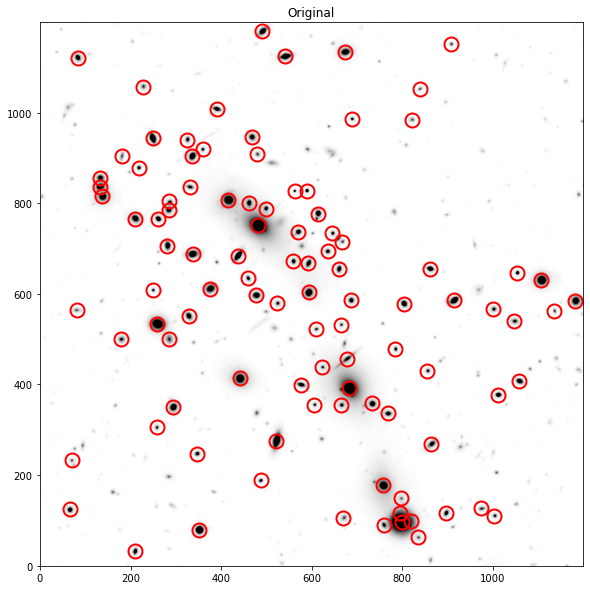

In [9]:
filename = "../../Exercise_11/MACSJ0416_HAWKI.fits"

data = fits.getdata(filename)
header = fits.getheader(filename)

fig = plt.figure(figsize=(10,10))

median = np.median(data)
vmin = median
vmax = vmin + 3*np.std(data)
plt.imshow(data, origin="lower", vmin=vmin, vmax=vmax, cmap="gray_r")
plt.title("Original")

Peaks = []
Xcoords = []
Ycoords = []

for i in range(100):
    peak  = np.max(data)
    coords  = np.where(data == peak)
    y, x = coords[0][0], coords[1][0]
    data[y-20:y+20, x-20:x+20] = median

    Peaks.append(peak)
    Xcoords.append(x)
    Ycoords.append(y)
    
plt.plot(Xcoords, Ycoords, "o", color="None", mec="r", ms=14, mew=2)    

tbl = Table(data=[Xcoords, Ycoords, Peaks], names=["X", "Y", "Peak"])
    
tbl.write("Results_photometry.csv", format="ascii.csv", overwrite=True)

### Question 5

The file ``Lightcurve.txt`` contains the lightcurve of an ACV-Type variable star.
   The first column contains the time in days while the second column shows the relative brightness change.
   Plot the lightcurve using ``matplotlib``.

   Now determine aimport numpy as np
import scipy.fft as fft
import matplotlib.pyplot as plt


data = np.genfromtxt("202066571.txt")

plt.plot(data[:,0], data[:,1])
plt.xlabel("Days")
plt.ylabel("Flux-Variation [mag]")
plt.show()

N = len(data[:,0])
T = (data[-1,0]-data[0,0])/N
flux_ft = fft.fft(data[:,1])
frequency = fft.fftfreq(N, T)[:N//2]
magnitude = 2.0/N * np.abs(flux_ft[0:N//2])

print("Highest frequency is:", frequency[np.argmax(magnitude)], "/days")

plt.plot(frequency, magnitude)
plt.xlabel("Frequency [1d]")
plt.ylabel("Magnitude in frequency domain")
plt.show()
nd plot the discrete Fourier Transform of the lightcurve using the functions ``fft`` and ``fftfreq``
   from ``scipy.fft``.

   Assume that the sample spacing of the time is constant. Then find the main frequency of the star by
   determining the frequency of the maximum magnitude in the transformed lightcurve.
   If you have issues you can look at the example for plotting the FFT of two sines in the ``1D discrete Fourier Transform`` section of [https://docs.scipy.org/doc/scipy/reference/tutorial/fft.html#id10](https://docs.scipy.org/doc/scipy/reference/tutorial/fft.html#id10) .  

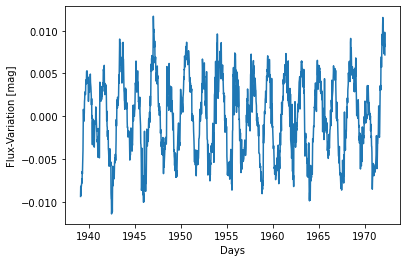

Highest frequency is: 0.5747402302878231 /days


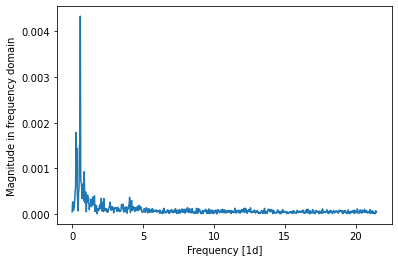

In [10]:
import scipy.fft as fft

data = np.genfromtxt("../202066571.txt")

plt.plot(data[:,0], data[:,1])
plt.xlabel("Days")
plt.ylabel("Flux-Variation [mag]")
plt.show()

N = len(data[:,0])
T = (data[-1,0]-data[0,0])/N
flux_ft = fft.fft(data[:,1])
frequency = fft.fftfreq(N, T)[:N//2]
magnitude = 2.0/N * np.abs(flux_ft[0:N//2])

print("Highest frequency is:", frequency[np.argmax(magnitude)], "/days")

plt.plot(frequency, magnitude)
plt.xlabel("Frequency [1d]")
plt.ylabel("Magnitude in frequency domain")
plt.show()
